The following is from [this article](https://medium.com/@arshren/deep-q-learning-a-deep-reinforcement-learning-algorithm-f1366cf1b53d) in Medium.

# 1. Deep Reinforcement Learning

Deep Reinforcement Learning combines Reinforcement Learning algorithms with Artificial Neural Networks. It allows the agent to learn an optimal policy for sequential decision problems by maximizing the cumulative future reward.

Reinforcement Learning is a goal-oriented algorithm where the agent aims to find optimal actions for a given state in an environment to maximize the long-term reward.

A Policy is a mapping of the states to actions that define the behavior of an agent in an environment. However, an Optimized Policy is a policy in which the agent is trained to maximize the cumulative reward over time.

The goal of reinforcement learning is to find an optimized policy that maps optimal actions the agent takes for the different environmental states.

The policies can be represented using a lookup table, linear functions, or neural networks depending on the complexity of the action space and state space for the environment. An optimal policy is derived by selecting the highest valued action in each state.

> For a low-dimensional state space and action space, a lookup table like a Q-table might be an excellent choice to represent a policy; however, when we have high-dimensional state spaces and action spaces, a neural network might be the option to learn optimized policies.

Neural Networks are several layers of nodes that approximate the function represented by the input data. Hence, a neural network can approximate a value function or a policy function to map states to values or state-action pairs to Q values.

# 2. Deep Q Learning

Deep Q learning is a deep Q-network(DQN) that combines Q learning Reinforcement Learning with a deep neural network.

If the state of the environment is represented as a vector of numbers, then use a fully-connected neural network. However, when the input data has a grid-like structure, such as an image, then use the convolutional neural network, which uses hierarchical layers of tiled convolutional filters to mimic the effects of receptive fields.

> Q-Learning is an off-policy temporal difference algorithm to find the optimal policy by updating the state-action value function(Q) at every step using the Bellman Optimality equation.

<img src="equ_2.webp" style="width:800px;height:50px;background-color:white">

Q-Learning, an off-policy algorithm, uses behavioral and target policies. A behavioral policy is used to explore the environment and to collect samples generating the agent’s behavior, and a target policy is learned, which is optimized.

The initial state is fed as an input to the neural network and returns the Q-value of all possible actions as an output.

<img src="figure_3.webp" style="width:800px;height:400px;background-color:white">

# 3. Challenges using the Neural Network for RL

Reinforcement Learning is known to be unstable or even to diverge when a neural network is used to represent the nonlinear function approximator or represent the Q function, also referred to as the action-value function.

The reason for instability is due to

- Correlation between the Q-values and the target values: Correlations present in the sequence of observations, the fact that small updates may significantly change the policy and therefore change the data distribution,
- Non-stationary target: There is a correlation between the action values (Q) and the target values

The target value is not stationary and keeps changing with every iteration, unlike in a typical neural network where the target is fixed and does not change.

# 4. Addressing the instabilities in Deep Neural Networks for Reinforcement Learning

The instabilities in a deep neural network for RL are resolved with a novel variant of Q-learning using two key ideas.

1. Experience Play
2. Target Network

## 4.1. Experience Play

Experience play is a technique to stabilize the training of the Q-function by allowing the agent to revisit and learn from past experiences.

The agent's experience: state, action, reward, and next state(Sₜ, Aₜ, Rₜ, Sₜ+₁) at each time step are stored in a replay memory. During the training, the agent randomly samples a batch of experiences from the replay memory to update the Q function.

Experience play removes the correlation in the observation sequence and smoothes the changes in data distribution. It also allows the agent to learn from diverse experiences to stabilize the learning process.

## 4.2. Target Network

Target network is a copy of the Q-network, which is used to approximate the Q-function.

The Target network maintains a separate weight vector θ⁻ to create a temporal gap between the target action-value function and the Q network's action-value function that is continually updated.

<img src="figure_4.webp" style="width:800px;height:500px;background-color:white">

The Target network parameters, θ⁻, are only updated with the Q-network parameters, θ, in every C step and are held fixed between individual updates. C is the period of time chosen as a hyper-parameter.

<img src="equ_3.webp" style="width:800px;height:50px;background-color:white">

Choosing a separate Target network makes divergence unlikely as it adds a delay between the time the Q value is updated and the time the target Qᵀ values are updated.

The Target network stabilizes the training process of the DQN by allowing the Target network to be relatively stable while incorporating the most recent changes to the Q Network.

# 5. Pytorch Implementation of Deep Q-learning

We will train the [CartPole-V1](https://gymnasium.farama.org/environments/classic_control/cart_pole/) using Deep Q-learning

- **Task** : The goal is for the agent to balance the pole by applying forces in the left and right direction on the cart where the pendulum is placed upright.

- **Action space** : There are two actions the agent can take. 0:Pushcart to the left, and 1:Pushcart to the right

<img src="table_1.webp" style="width:800px;height:250px;background-color:white">

- **Rewards** : The agent receives a reward of +1 for every time step that the pole remains upright on the cart, including the termination step. The threshold for rewards is 500 for v1.

In [1]:
# importing required libraries
import math
import random
from collections import deque, namedtuple
from itertools import count

import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython import display

Setting up the device as well as setting the plot in the interactive mode of the matplotlib. This will allow the figures and plots to be open in a separate window and will be updated while the script runs.

In [2]:
plt.ion()

# setting the device
# if gpu is to be used for Mac OS
# device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
# if gpu is to be used for cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


**Deep Q-learning uses Experience play** to stabilize the training by learning from the agent’s past experiences.

The agent’s experience: state, action, reward, and next state(Sₜ, Aₜ, Rₜ, Sₜ+₁) at each time step are stored in a replay memory

In [3]:
# structure of the Experiences to store
Experience = namedtuple("Experience", ("state", "action", "next_state", "reward"))

In [4]:
# stores the Experience Replay buffer
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        # Save the Experience into memory
        self.memory.append(Experience(*args))

    def sample(self, batch_size):
        # selecting a random batch of Experience for training
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## 5.1. Building the DQN(Deep Q-Network)

As the state of the cartPole-v1 environment is represented as a vector of numbers, we will use a fully-connected neural network with three layers.

In [5]:
class DQN(nn.Module):
    """
    Args:
        n_observations: observation/state size of the environment
        n_actions: number of discrete actions available in the environment
        hidden_size: size of hidden layers
    """

    def __init__(self, n_observations, n_actions, hidden_size):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## 5.2. Setting the values for the Hyperparameters

In [6]:
BATCH_SIZE = (
    128  # BATCH_SIZE is the number of Experience sampled from the replay buffer
)
GAMMA = 0.99  # GAMMA is the discount factor as mentioned in the previous section
EPSILON_START = 0.9  # EPSILON_START is the starting value of epsilon
EPSILON_END = 0.05  # EPSILON_END is the final value of epsilon
EPSILON_DECAY = 1000  # EPSILON_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.005  # TAU is the update rate of the target network
LR = 1e-4  # LR is the learning rate of the AdamW optimizer
HIDDEN_SIZE = 128  # the hidden layers in the DQN

## 5.3. Perform an Action

An action will be chosen based on an epsilon greedy policy.

> Epsilon greedy policy allows the agent selects an action with the highest reward with a probability of 1-epsilon to exploit the best action for the state and selects a random action with a probability of epsilon to explore the environment.

The epsilon parameter controls the balance between exploration and exploitation.

The probability of choosing a random action will start at `EPSILON_START` and decay exponentially towards `EPSILON_END`.

`EPSILON_DECAY` controls the rate of decay.

In [7]:
def choose_action(state):
    global steps_done
    sample = random.random()
    epsilon_threshold = EPSILON_END + (EPSILON_START - EPSILON_END) * math.exp(
        -1.0 * steps_done / EPSILON_DECAY
    )

    steps_done += 1
    if sample > epsilon_threshold:
        # max(1) will return largest column value of each row.
        # second column on max result is index of where max element was found
        # so we pick action with the larger expected reward.
        with torch.no_grad():
            return policy_network(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor(
            [[env.action_space.sample()]], device=device, dtype=torch.long
        )

## 5.4. Plot the duration of training and results

In [8]:
"""
Function to plot the durations of episodes, 
along with an average over the last 100 episodes
"""


def plot_scores(show_result=False):
    plt.figure(1)
    duration_t = torch.tensor(episode_duration, dtype=torch.float)
    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")

    plt.xlabel("Episode")
    plt.ylabel("Duration")
    plt.plot(duration_t.numpy())
    # Take 100 episode averages and plot them too
    if len(duration_t) >= 100:
        means = duration_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.pause(0.001)  # pause a bit so that plots are updated
    if not show_result:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())

## 5.5. Optimize the model one single step at a time.

compute

- Q(Sₜ, Aₜ): the actions the agent would have taken for each batch state according to policy_net
- V(Sₜ+₁) : the target network compute maxₐQ(Sₜ+₁, a) for all next states for stability
- Expected Q value: reward + (γ * V(Sₜ+₁))

Compute Huber loss which acts like the mean squared error when the error is small but acts like the mean absolute error when the error is large, making it more robust to outliers when the estimates of Q are very noisy

The Target network has its weights kept frozen most of the time but is updated with the Policy network’s weights every so often. This is usually a set number of steps, but we shall use episodes for simplicity when training the DQN.

The gradient clipping is performed to optimize the policy network. If the gradients of the parameters of the policy network exceed 100 in magnitude, they will be set to 100 (or -100 if they are negative).

In [9]:
# function that performs a single step of the optimization
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transition = memory.sample(BATCH_SIZE)

    """
    # Transpose the batch and convert the  batch-array of Experience
    # to Transition of batch-arrays
    """
    batch = Experience(*zip(*transition))

    # Compute a mask of non-final states and concatenate the batch element

    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool,
    )
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a)
    # These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_network(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    with torch.no_grad():
        next_state_values[non_final_mask] = target_network(non_final_next_states).max(
            1
        )[0]
    # Compute the expected Q values
    expected_state_action_values = reward_batch + (GAMMA * next_state_values)

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # optimize the model
    optimizer.zero_grad()
    loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_network.parameters(), 100)
    optimizer.step()

## 5.6. Train the Agent

The main training loop uses a fixed number of episodes and steps to train.

In the beginning, reset the environment using `env.reset()` and obtain the initial `state` Tensor. Then, sample an action `choose_action(state)` to observe the next state and the reward.

The training loop uses a replay buffer to store experiences, a Target network, and a Policy network. The Target network's parameters are updated with the Policy network's parameters.

The agent will perform a soft update of the Target Network’s weights as it makes the Target Network’s weights converge to the Policy Network’s weights.

In [10]:
# Get number of actions from gym action space
env = gym.make("CartPole-v1")
n_actions = env.action_space.n
state = env.reset()[0]
n_observations = len(state)

In [11]:
policy_network = DQN(n_observations, n_actions, HIDDEN_SIZE).to(device)
target_network = DQN(n_observations, n_actions, HIDDEN_SIZE).to(device)
# updates the parameters of the target network  with the parameters of the policy network
target_network.load_state_dict(policy_network.state_dict())

<All keys matched successfully>

In [12]:
optimizer = optim.AdamW(policy_network.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0
episode_duration = []
num_episodes = 391

In [13]:
for i in range(num_episodes):
    # At the beginning we reset the environment and
    # initialize the state Tensor.
    state = env.reset()[0]
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0
    for t in count():
        # sample an action
        action = choose_action(state)
        # execute it, observe the next screen and the reward
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(
                observation, dtype=torch.float32, device=device
            ).unsqueeze(0)

        # Store the experience in the memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        # The agent  performs an optimization step on the Policy Network using the stored memory
        optimize_model()

        """
        The agent will perform a soft update of the Target Network's weights, 
        with the equation TAU * policy_net_state_dict + (1-TAU) * target_net_state_dict, 
        this helps to make the Target Network's weights converge to the Policy Network's weights.
        """
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        # policy_network.state_dict() returns the parameters of the policy network
        # target_network.load_state_dict() loads these parameters into the target network.
        target_net_state_dict = target_network.state_dict()
        policy_net_state_dict = policy_network.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[
                key
            ] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_network.load_state_dict(target_net_state_dict)
        total_reward += reward
        if done:
            episode_duration.append(t + 1)
            if i%10 == 0:
                print(
                    "Episode",
                    i,
                    "Game terminated after",
                    t,
                    "steps with reward",
                    total_reward,
                )

            break

print("Complete")

Episode 0 Game terminated after 9 steps with reward tensor([10.])
Episode 10 Game terminated after 18 steps with reward tensor([19.])
Episode 20 Game terminated after 9 steps with reward tensor([10.])
Episode 30 Game terminated after 11 steps with reward tensor([12.])
Episode 40 Game terminated after 10 steps with reward tensor([11.])
Episode 50 Game terminated after 17 steps with reward tensor([18.])
Episode 60 Game terminated after 8 steps with reward tensor([9.])
Episode 70 Game terminated after 20 steps with reward tensor([21.])
Episode 80 Game terminated after 12 steps with reward tensor([13.])
Episode 90 Game terminated after 26 steps with reward tensor([27.])
Episode 100 Game terminated after 10 steps with reward tensor([11.])
Episode 110 Game terminated after 9 steps with reward tensor([10.])
Episode 120 Game terminated after 10 steps with reward tensor([11.])
Episode 130 Game terminated after 12 steps with reward tensor([13.])
Episode 140 Game terminated after 17 steps with re

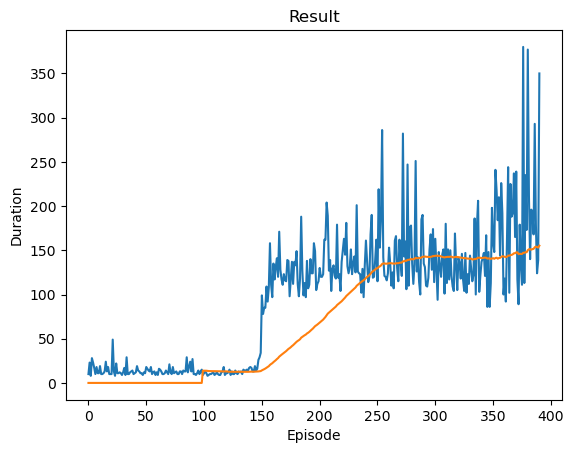

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [14]:
plot_scores(show_result=True)
plt.ioff()
plt.show()

<img src="figure_5.webp" style="width:800px;height:350px;background-color:white">